 # Connectome Aggregation Test (Multiple Methods)



 Testing if different aggregation methods (`add`, `mean`, `min`, `max`)

 reproduce the reported gap junction asymmetry.

In [29]:
# Import necessary libraries
import torch
import networkx as nx
import matplotlib.pyplot as plt
import os
import glob
from torch_geometric.utils import coalesce
import numpy as np


 ## 1. Configuration and File Discovery (Same as before)

In [30]:
# Define the root directory (adjust if your notebook is elsewhere relative to data)
ROOT_DIR = os.path.abspath(".")  # Or specify the absolute path if needed

# Directory containing the processed connectome files
PROCESSED_CONNECTOME_DIR = os.path.join(ROOT_DIR, "data", "processed", "connectome")

# Find all files starting with 'graph_tensors' and ending with '.pt'
pt_files = glob.glob(os.path.join(PROCESSED_CONNECTOME_DIR, "graph_tensors*.pt"))

if not pt_files:
    print(f"ERROR: No '.pt' files found in: {PROCESSED_CONNECTOME_DIR}")
    raise FileNotFoundError(f"No connectome files found in {PROCESSED_CONNECTOME_DIR}")
else:
    print(f"Found {len(pt_files)} connectome files to aggregate:")
    for f in pt_files:
        print(f"- {os.path.basename(f)}")


Found 2 connectome files to aggregate:
- graph_tensors_openworm.pt
- graph_tensors_default.pt


 ## 2. Load Metadata and Concatenate Edge Data (Same as before)

In [31]:
# Load metadata from the first file
first_file_path = pt_files[0]
print(
    f"\nLoading metadata (node labels, positions) from: {os.path.basename(first_file_path)}"
)
try:
    first_graph_data = torch.load(first_file_path)
except Exception as e:
    print(f"Error loading metadata from {first_file_path}: {e}")
    raise

node_label = first_graph_data.get("node_label")
pos = first_graph_data.get("pos")
num_nodes = len(node_label) if node_label else 0

if not node_label:
    print(
        "ERROR: 'node_label' not found in the first file. Cannot proceed without node mapping."
    )
    raise ValueError("'node_label' is required for mapping.")
else:
    print(f"Using node labels for {num_nodes} neurons from the first file.")
    neuron_to_idx = {name: idx for idx, name in node_label.items()}

# Prepare layout (copied from previous script)
layout_pos = {}
# Prepare layout (handles both Tensor and Dict 'pos' formats)
layout_pos = {}
# Check if pos was loaded successfully (is not None)
if pos is not None:
    if isinstance(pos, torch.Tensor):
        print("Processing 'pos' data as Tensor.")
        # Ensure tensor shape is reasonable (N x 2 or N x 3)
        if pos.ndim == 2 and pos.shape[0] == num_nodes and pos.shape[1] >= 2:
            # Iterate through the node indices we expect based on node_label
            for node_idx in node_label.keys():
                # Tensor row index corresponds to node index
                coords = pos[node_idx].tolist()  # Get coordinates for this node
                layout_pos[node_idx] = coords[:2]  # Take X, Y
        else:
            print(
                f"Warning: Loaded 'pos' Tensor has unexpected shape {pos.shape}. Expected ({num_nodes}, >=2). Falling back to default layout."
            )
            layout_pos = None  # Fallback

    # Handle unexpected formats
    else:
        print(
            f"Warning: Loaded 'pos' data is of unexpected type {type(pos)}. Falling back to default layout."
        )
        layout_pos = None

# Handle case where pos was None initially or processing failed
if pos is None or layout_pos is None:
    print("No valid position data found or processed. Using NetworkX default layout.")
    # Setting layout_pos explicitly to None if it failed allows fallback later
    layout_pos = None
elif not layout_pos:
    print(
        "Warning: Position data processed, but resulting layout_pos dictionary is empty. Using default layout."
    )
    layout_pos = None
else:
    print(f"Successfully created layout dictionary for {len(layout_pos)} nodes.")


# Initialize lists and concatenate data (same as before)
all_edge_indices = []
all_edge_attrs = []
print("\nStarting data extraction from all files...")
for file_path in pt_files:
    # (Include the validation and loading loop from the previous script here)
    # ... (ensure you copy the loop that appends to all_edge_indices/attrs) ...
    print(f"Processing: {os.path.basename(file_path)}")
    try:
        graph_data = torch.load(file_path)
        edge_index = graph_data.get("edge_index")
        edge_attr = graph_data.get("edge_attr")
        if (
            edge_index is not None
            and edge_attr is not None
            and isinstance(edge_index, torch.Tensor)
            and isinstance(edge_attr, torch.Tensor)
            and edge_index.ndim == 2
            and edge_index.shape[0] == 2
            and edge_attr.ndim == 2
            and edge_attr.shape[1] == 2
            and edge_index.shape[1] == edge_attr.shape[0]
            and edge_index.shape[1] > 0
        ):
            all_edge_indices.append(edge_index)
            all_edge_attrs.append(edge_attr)
            print(f"  -> Added {edge_index.shape[1]} edges.")
        else:
            print(f"  -> Skipping: Invalid or missing edge data.")
            if edge_index is not None and edge_attr is not None:
                print(
                    f"     Shapes: index={edge_index.shape if isinstance(edge_index, torch.Tensor) else 'N/A'}, attr={edge_attr.shape if isinstance(edge_attr, torch.Tensor) else 'N/A'}"
                )

    except Exception as e:
        print(f"  -> Error processing file {os.path.basename(file_path)}: {e}")

if not all_edge_indices or not all_edge_attrs:
    print("\nERROR: No valid edge data could be collected from any file.")
    raise ValueError("Aggregation failed, no data.")

combined_edge_index = torch.cat(all_edge_indices, dim=1)
combined_edge_attr = torch.cat(all_edge_attrs, dim=0)
print(f"\nTotal edges before aggregation: {combined_edge_index.shape[1]}")




Loading metadata (node labels, positions) from: graph_tensors_openworm.pt
Using node labels for 300 neurons from the first file.
Processing 'pos' data as Tensor.
Successfully created layout dictionary for 300 nodes.

Starting data extraction from all files...
Processing: graph_tensors_openworm.pt
  -> Added 90000 edges.
Processing: graph_tensors_default.pt
  -> Added 90000 edges.

Total edges before aggregation: 180000


 ## 3. Define Graph Building and Visualization Functions

In [32]:
def build_nx_graph(edge_index, edge_attr, num_nodes, node_label_map):
    """Builds NetworkX graph from aggregated tensors."""
    G = nx.DiGraph()
    if node_label_map:
        for node_idx, node_name in node_label_map.items():
            G.add_node(node_idx, label=node_name)
    else:
        G.add_nodes_from(range(num_nodes))

    num_edges_added = 0
    if edge_index is not None and edge_attr is not None:
        if edge_index.shape[1] == edge_attr.shape[0]:
            for i in range(edge_index.shape[1]):
                source_node = edge_index[0, i].item()
                target_node = edge_index[1, i].item()
                if source_node < num_nodes and target_node < num_nodes:
                    gap_weight = edge_attr[i, 0].item()
                    chem_weight = edge_attr[i, 1].item()
                    G.add_edge(
                        source_node, target_node, gap=gap_weight, chem=chem_weight
                    )
                    num_edges_added += 1
            print(f"Built graph with {num_edges_added} edges.")
        else:
            print(
                "ERROR building graph: Mismatch between edge_index and edge_attr shapes after coalesce."
            )
    else:
        print(
            "Skipping edge addition as aggregated edge_index or edge_attr is missing."
        )
    return G


# Use the same visualize_connectome function from the previous script
# Make sure it's defined in this notebook scope
def visualize_connectome(
    graph,
    layout,
    focus_neurons=None,
    node_label_map=None,
    neuron_to_idx_map=None,
    show_edge_labels=True,
    label_threshold=0.1,
    figsize=(15, 15),
    title_prefix="",
):
    """
    Visualizes the connectome graph or a subgraph around focus neurons.
    (Added title_prefix)
    """
    plt.figure(figsize=figsize)
    node_indices_to_draw = list(graph.nodes())
    subgraph = graph
    effective_layout = layout  # Start with the full layout

    if focus_neurons and neuron_to_idx_map:
        focus_indices = [
            neuron_to_idx_map.get(name)
            for name in focus_neurons
            if neuron_to_idx_map.get(name) is not None
        ]
        focus_indices = [
            idx for idx in focus_indices if idx in graph
        ]  # Ensure nodes exist
        if focus_indices:
            print(f"Focusing on neurons: {focus_neurons} (Indices: {focus_indices})")
            subgraph = graph.subgraph(focus_indices).copy()
            node_indices_to_draw = list(subgraph.nodes())
            # Update layout for the subgraph
            effective_layout = {
                node: pos
                for node, pos in layout.items()
                if node in node_indices_to_draw
            }
            if not effective_layout and node_indices_to_draw:
                print("Generating layout for subgraph...")
                effective_layout = nx.spring_layout(subgraph)
        else:
            print(
                f"Warning: Focus neurons {focus_neurons} not found in the current graph."
            )
            node_indices_to_draw = []  # Don't draw anything

    if not node_indices_to_draw:
        print("No nodes to draw.")
        plt.close()
        return

    node_names_to_draw = {
        idx: node_label_map.get(idx, str(idx)) for idx in node_indices_to_draw
    }
    nx.draw_networkx_nodes(
        subgraph,
        effective_layout,
        nodelist=node_indices_to_draw,
        node_size=300,
        node_color="lightcoral",
        alpha=0.8,
    )
    nx.draw_networkx_labels(
        subgraph, effective_layout, labels=node_names_to_draw, font_size=8
    )

    edges_to_draw = list(subgraph.edges(data=True))
    if edges_to_draw:
        epsilon = 1e-6
        gap_edges = [
            (u, v) for u, v, d in edges_to_draw if abs(d.get("gap", 0)) > epsilon
        ]
        chem_edges = [
            (u, v) for u, v, d in edges_to_draw if abs(d.get("chem", 0)) > epsilon
        ]
        nx.draw_networkx_edges(
            subgraph,
            effective_layout,
            edgelist=gap_edges,
            edge_color="blue",
            alpha=0.6,
            arrows=True,
            arrowstyle="->",
            connectionstyle="arc3,rad=0.1",
        )
        nx.draw_networkx_edges(
            subgraph,
            effective_layout,
            edgelist=chem_edges,
            edge_color="red",
            alpha=0.6,
            arrows=True,
            arrowstyle="->",
            connectionstyle="arc3,rad=-0.1",
        )

        if show_edge_labels:
            edge_labels = {}
            for u, v, data in edges_to_draw:
                gap_w, chem_w = data.get("gap", 0), data.get("chem", 0)
                label_parts = []
                if abs(gap_w) >= label_threshold:
                    label_parts.append(f"G:{gap_w:.3f}")
                if abs(chem_w) >= label_threshold:
                    label_parts.append(f"C:{chem_w:.3f}")
                if label_parts:
                    edge_labels[(u, v)] = "\n".join(label_parts)
            if edge_labels:
                nx.draw_networkx_edge_labels(
                    subgraph,
                    effective_layout,
                    edge_labels=edge_labels,
                    font_size=7,
                    font_color="black",
                    bbox=dict(
                        facecolor="white",
                        alpha=0.5,
                        edgecolor="none",
                        boxstyle="round,pad=0.1",
                    ),
                )
            else:
                print("No edge labels above threshold.")
    else:
        print("No edges to draw in selection.")

    plt.title(
        f"{title_prefix} Aggregated Connectome (Focus: {focus_neurons if focus_neurons else 'All'})"
    )
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.axis("on")
    ax = plt.gca()
    if effective_layout:
        ax.set_aspect("equal", adjustable="box")
    plt.show()



 ## 4. Test Different Aggregation Methods


--- Aggregating using reduce='add' ---
Edges after 'add' aggregation: 90000

--- Exact Weights for Method='add' ---
  VD1 -> VD2: Gap=11.000, Chem=0.000
  VD2 -> VD1: Gap=11.000, Chem=0.000
  -> Gap weights are symmetric.
  VD2 -> VD2: Gap=3.000, Chem=0.000
Built graph with 90000 edges.
Focusing on neurons: ['VD1', 'VD2'] (Indices: [287, 292])


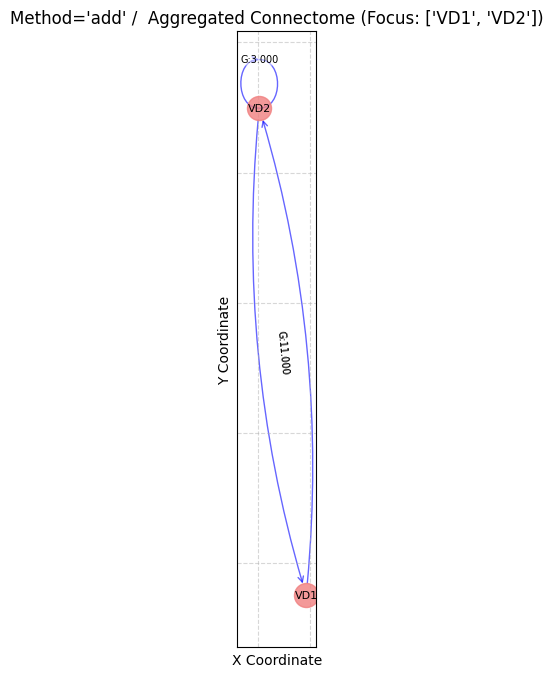


--- Aggregating using reduce='mean' ---
Edges after 'mean' aggregation: 90000

--- Exact Weights for Method='mean' ---
  VD1 -> VD2: Gap=5.500, Chem=0.000
  VD2 -> VD1: Gap=5.500, Chem=0.000
  -> Gap weights are symmetric.
  VD2 -> VD2: Gap=1.500, Chem=0.000
Built graph with 90000 edges.
Focusing on neurons: ['VD1', 'VD2'] (Indices: [287, 292])


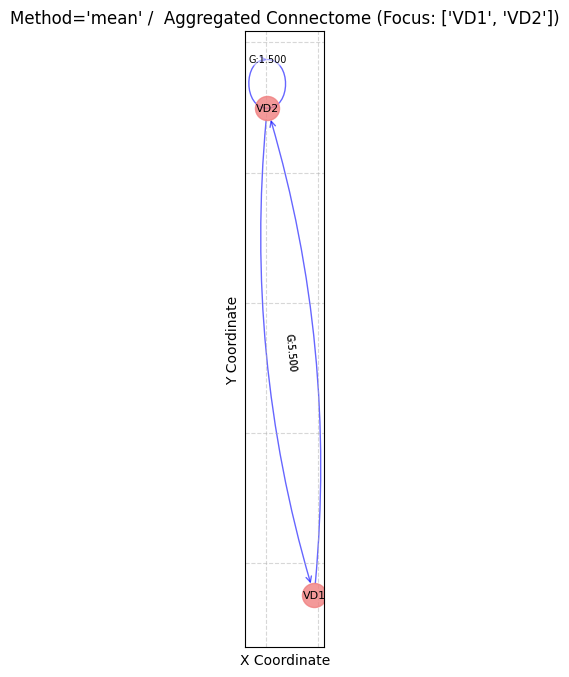


--- Aggregating using reduce='max' ---
Edges after 'max' aggregation: 90000

--- Exact Weights for Method='max' ---
  VD1 -> VD2: Gap=7.000, Chem=0.000
  VD2 -> VD1: Gap=7.000, Chem=0.000
  -> Gap weights are symmetric.
  VD2 -> VD2: Gap=3.000, Chem=0.000
Built graph with 90000 edges.
Focusing on neurons: ['VD1', 'VD2'] (Indices: [287, 292])


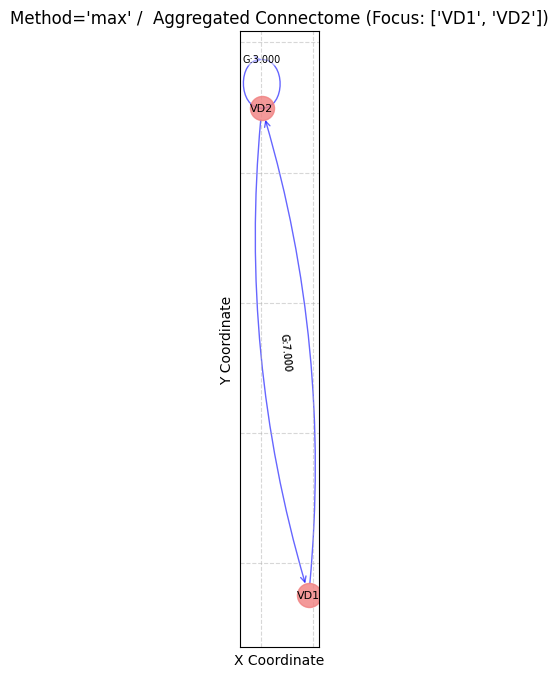


--- Aggregating using reduce='min' ---
Edges after 'min' aggregation: 90000

--- Exact Weights for Method='min' ---
  VD1 -> VD2: Gap=4.000, Chem=0.000
  VD2 -> VD1: Gap=4.000, Chem=0.000
  -> Gap weights are symmetric.
  VD2 -> VD2: Gap=0.000, Chem=0.000
Built graph with 90000 edges.
Focusing on neurons: ['VD1', 'VD2'] (Indices: [287, 292])


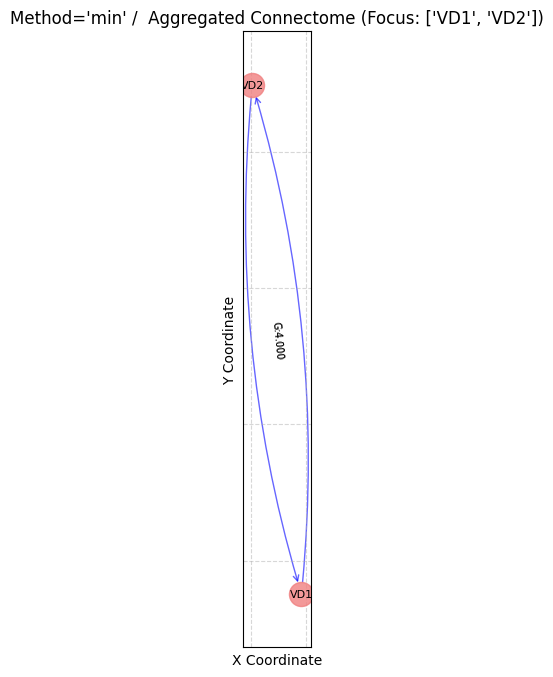

In [33]:
neurons_of_interest = ["VD1", "VD2"]
reduce_methods = ["add", "mean", "max", "min"]  # Methods to test

# Generate the base layout using combined data before aggregation if needed
if not layout_pos:
    print("Generating default spring layout using pre-coalesce data...")
    # Build temporary graph just for layout
    G_temp_layout = nx.DiGraph()
    G_temp_layout.add_nodes_from(range(num_nodes))
    # Add only a subset of edges for performance if graph is huge
    num_layout_edges = min(combined_edge_index.shape[1], 10000)
    for i in range(num_layout_edges):
        u, v = combined_edge_index[0, i].item(), combined_edge_index[1, i].item()
        if u < num_nodes and v < num_nodes:
            G_temp_layout.add_edge(u, v)
    layout_pos = nx.spring_layout(G_temp_layout)
    print("Default layout generated.")


for method in reduce_methods:
    print(f"\n--- Aggregating using reduce='{method}' ---")
    agg_edge_index, agg_edge_attr = coalesce(
        combined_edge_index, combined_edge_attr, num_nodes=num_nodes, reduce=method
    )
    print(f"Edges after '{method}' aggregation: {agg_edge_index.shape[1]}")
    
    print(f"\n--- Exact Weights for Method='{method}' ---")
    vd1_idx = neuron_to_idx.get("VD1")
    vd2_idx = neuron_to_idx.get("VD2")

    if vd1_idx is None or vd2_idx is None:
        print("  VD1 or VD2 index not found in mapping.")
    else:
        # Find edge VD1 -> VD2
        edge12_mask = (agg_edge_index[0] == vd1_idx) & (agg_edge_index[1] == vd2_idx)
        edge12_indices = torch.where(edge12_mask)[0]  # Get indices in the tensor

        if len(edge12_indices) > 0:
            idx_in_tensor = edge12_indices[0]  # Assume only one edge after coalesce
            attr12 = agg_edge_attr[idx_in_tensor]
            print(
                f"  VD1 -> VD2: Gap={attr12[0].item():.3f}, Chem={attr12[1].item():.3f}"
            )
        else:
            print("  VD1 -> VD2: Edge not found in aggregated data.")

        # Find edge VD2 -> VD1
        edge21_mask = (agg_edge_index[0] == vd2_idx) & (agg_edge_index[1] == vd1_idx)
        edge21_indices = torch.where(edge21_mask)[0]

        if len(edge21_indices) > 0:
            idx_in_tensor = edge21_indices[0]
            attr21 = agg_edge_attr[idx_in_tensor]
            print(
                f"  VD2 -> VD1: Gap={attr21[0].item():.3f}, Chem={attr21[1].item():.3f}"
            )
            # Check for symmetry directly
            if len(edge12_indices) > 0 and not torch.isclose(
                attr12[0], attr21[0], atol=1e-5
            ):
                print("  -> WARNING: Gap weights are ASYMMETRIC!")
            elif len(edge12_indices) > 0:
                print("  -> Gap weights are symmetric.")

        else:
            print("  VD2 -> VD1: Edge not found in aggregated data.")

        # Find edge VD2 -> VD2 (self-loop)
        edge22_mask = (agg_edge_index[0] == vd2_idx) & (agg_edge_index[1] == vd2_idx)
        edge22_indices = torch.where(edge22_mask)[0]

        if len(edge22_indices) > 0:
            idx_in_tensor = edge22_indices[0]
            attr22 = agg_edge_attr[idx_in_tensor]
            print(
                f"  VD2 -> VD2: Gap={attr22[0].item():.3f}, Chem={attr22[1].item():.3f}"
            )
        else:
            print("  VD2 -> VD2: Self-loop not found in aggregated data.")

    # Build graph for this method
    G_method = build_nx_graph(agg_edge_index, agg_edge_attr, num_nodes, node_label)

    # Visualize VD1/VD2 connection for this method
    visualize_connectome(
        G_method,
        layout_pos,
        focus_neurons=neurons_of_interest,
        node_label_map=node_label,
        neuron_to_idx_map=neuron_to_idx,
        show_edge_labels=True,
        label_threshold=0.01,
        figsize=(8, 8),
        title_prefix=f"Method='{method}' / ",
    )

